<a href="https://colab.research.google.com/github/MuhtasimMahadi/Muhtasim_Hossain/blob/main/fullFNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! nvidia-smi

Tue Dec  5 15:15:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


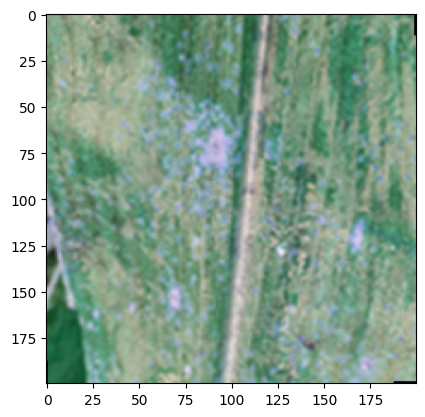

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm

DATADIR = "/content/drive/MyDrive/titl_defence/Dataset/final_crop_image"

CATEGORIES = ["Common_rust", "gray_leaf_spot", "healthy"]

for category in CATEGORIES:  # do dogs and cats
    path = os.path.join(DATADIR,category)  # create path to dogs and cats
    for img in os.listdir(path):  # iterate over each image per dogs and cats
        img_array = cv2.imread(os.path.join(path,img))  # convert to array
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  # display!

        break  # we just want one for now so break
    break  #...and one more!

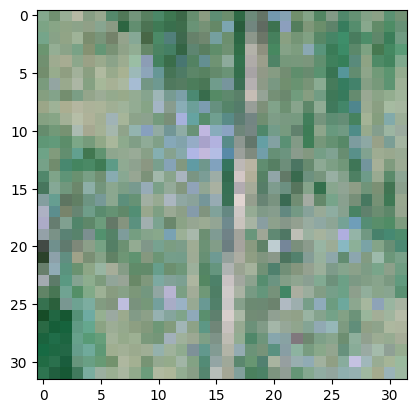

In [ ]:
IMG_SIZE = 32

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array)
plt.show()

In [ ]:
training_data = []

def create_training_data():
    for category in CATEGORIES:  # do dogs and cats

        path = os.path.join(DATADIR,category)  # create path to dogs and cats
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=dog 1=cat

        for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

100%|██████████| 3450/3450 [03:33<00:00, 16.16it/s]


In [ ]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)
X = np.array(X) / 255
X.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y)

In [ ]:
num_classes = 3
input_shape = (32, 32, 3)

#x_train, y_train, x_test, y_test = train_test_split(X, y, test_size=0.2)
(x_train, x_test, y_train, y_test) = train_test_split(X, y,
    test_size=0.2)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (8520, 32, 32, 3) - y_train shape: (8520,)
x_test shape: (2130, 32, 32, 3) - y_test shape: (2130,)


In [ ]:
weight_decay = 0.0001
batch_size = 128
num_epochs = 200
dropout_rate = 0.2
image_size = 64  # We'll resize input images to this size.
patch_size = 8  # Size of the patches to be extracted from the input images.
num_patches = (image_size // patch_size) ** 2  # Size of the data array.
embedding_dim = 256  # Number of hidden units.
num_blocks = 3  # Number of blocks.

print(f"Image size: {image_size} X {image_size} = {image_size ** 2}")
print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")
print(f"Elements per patch (3 channels): {(patch_size ** 2) * 3}")

Image size: 64 X 64 = 4096
Patch size: 8 X 8 = 64 
Patches per image: 64
Elements per patch (3 channels): 192


In [ ]:
def build_classifier(blocks, positional_encoding=False):
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size, num_patches)(augmented)
    # Encode patches to generate a [batch_size, num_patches, embedding_dim] tensor.
    x = layers.Dense(units=embedding_dim)(patches)
    if positional_encoding:
        positions = tf.range(start=0, limit=num_patches, delta=1)
        position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=embedding_dim
        )(positions)
        x = x + position_embedding
    # Process x using the module blocks.
    x = blocks(x)
    # Apply global average pooling to generate a [batch_size, embedding_dim] representation tensor.
    representation = layers.GlobalAveragePooling1D()(x)
    # Apply dropout.
    representation = layers.Dropout(rate=dropout_rate)(representation)
    # Compute logits outputs.
    logits = layers.Dense(num_classes)(representation)
    # Create the Keras model.
    return keras.Model(inputs=inputs, outputs=logits)

In [ ]:
# def run_experiment(model):
#     # Create Adam optimizer with weight decay.
#     optimizer = tfa.optimizers.AdamW(
#         learning_rate=learning_rate, weight_decay=weight_decay,
#     )
#     # Compile the model.
#     model.compile(
#         optimizer=optimizer,
#         loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#         metrics=[
#             keras.metrics.SparseCategoricalAccuracy(name="acc"),
#             keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc"),
#         ],
#     )
#     # Create a learning rate scheduler callback.
#     reduce_lr = keras.callbacks.ReduceLROnPlateau(
#         monitor="val_loss", factor=0.5, patience=5
#     )
#     # Create an early stopping callback.
#     early_stopping = tf.keras.callbacks.EarlyStopping(
#         monitor="val_loss", patience=10, restore_best_weights=True
#     )
#     # Fit the model.
#     history = model.fit(
#         x=x_train,
#         y=y_train,
#         batch_size=batch_size,
#         epochs=num_epochs,
#         validation_split=0.1,
#         callbacks=[early_stopping, reduce_lr],
#     )

#     _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
#     print(f"Test accuracy: {round(accuracy * 100, 2)}%")
#     print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

#     # Return history to plot learning curves.
#     return history

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
def run_experiment(model):
    # Create Adam optimizer with weight decay.
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay,
    )
    # Compile the model.
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )
    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5
    )
    # Create an early stopping callback.
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[early_stopping, reduce_lr],
    )

    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    # Get predictions
    ypred = model.predict(x_test, verbose=1)
    ypred = np.argmax(ypred, axis=1)

    target_names = labels =  ["Black Spot", "Downy mildew", "Fresh Leaf"]
    print(classification_report(y_test, ypred, target_names=target_names))

    cm = confusion_matrix(y_test, ypred)
    cm = pd.DataFrame(cm, range(3), range(3))
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, annot_kws={"size": 12})
    plt.show()

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

    return history

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size, num_patches):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        self.num_patches = num_patches

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, self.num_patches, patch_dims])
        return patches

FNet model

In [ ]:
class FNetLayer(layers.Layer):
    def __init__(self, num_patches, embedding_dim, dropout_rate, *args, **kwargs):
        super(FNetLayer, self).__init__(*args, **kwargs)

        self.ffn = keras.Sequential(
            [
                layers.Dense(units=embedding_dim),
                tfa.layers.GELU(),
                layers.Dropout(rate=dropout_rate),
                layers.Dense(units=embedding_dim),
            ]
        )

        self.normalize1 = layers.LayerNormalization(epsilon=1e-6)
        self.normalize2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Apply fourier transformations.
        x = tf.cast(
            tf.signal.fft2d(tf.cast(inputs, dtype=tf.dtypes.complex64)),
            dtype=tf.dtypes.float32,
        )
        # Add skip connection.
        x = x + inputs
        # Apply layer normalization.
        x = self.normalize1(x)
        # Apply Feedfowrad network.
        x_ffn = self.ffn(x)
        # Add skip connection.
        x = x + x_ffn
        # Apply layer normalization.
        return self.normalize2(x)

In [ ]:
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

Epoch 1/200


60/60 [==============================] - ETA: 0s - loss: 0.8713 - accuracy: 0.5846 - top-5-accuracy: 1.0000

60/60 [==============================] - 13s 54ms/step - loss: 0.8713 - accuracy: 0.5846 - top-5-accuracy: 1.0000 - val_loss: 0.5570 - val_accuracy: 0.7840 - val_top-5-accuracy: 1.0000 - lr: 0.0010
Epoch 2/200
60/60 [==============================] - 3s 42ms/step - loss: 0.5257 - accuracy: 0.7848 - top-5-accuracy: 1.0000 - val_loss: 0.4258 - val_accuracy: 0.8263 - val_top-5-accuracy: 1.0000 - lr: 0.0010
Epoch 3/200
60/60 [==============================] - 3s 43ms/step - loss: 0.4211 - accuracy: 0.8363 - top-5-accuracy: 1.0000 - val_loss: 0.4717 - val_accuracy: 0.7805 - val_top-5-accuracy: 1.0000 - lr: 0.0010
Epoch 4/200
60/60 [==============================] - 3s 47ms/step - loss: 0.3495 - accuracy: 0.8627 - top-5-accuracy: 1.0000 - val_loss: 0.3367 - val_accuracy: 0.8533 - val_top-5-accuracy: 1.0000 - lr: 0.0010
Epoch 5/200
60/60 [==============================] - 3s 46ms/step - loss: 0.3095 - accuracy: 0.8774 - top-5-accuracy: 1.0000 - val_loss: 0.2420 - val_accuracy: 0.9131 - val_to

67/67 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

  Black Spot       1.00      0.99      1.00       750
Downy mildew       0.99      1.00      1.00       681
  Fresh Leaf       1.00      1.00      1.00       699

    accuracy                           1.00      2130
   macro avg       1.00      1.00      1.00      2130
weighted avg       1.00      1.00      1.00      2130



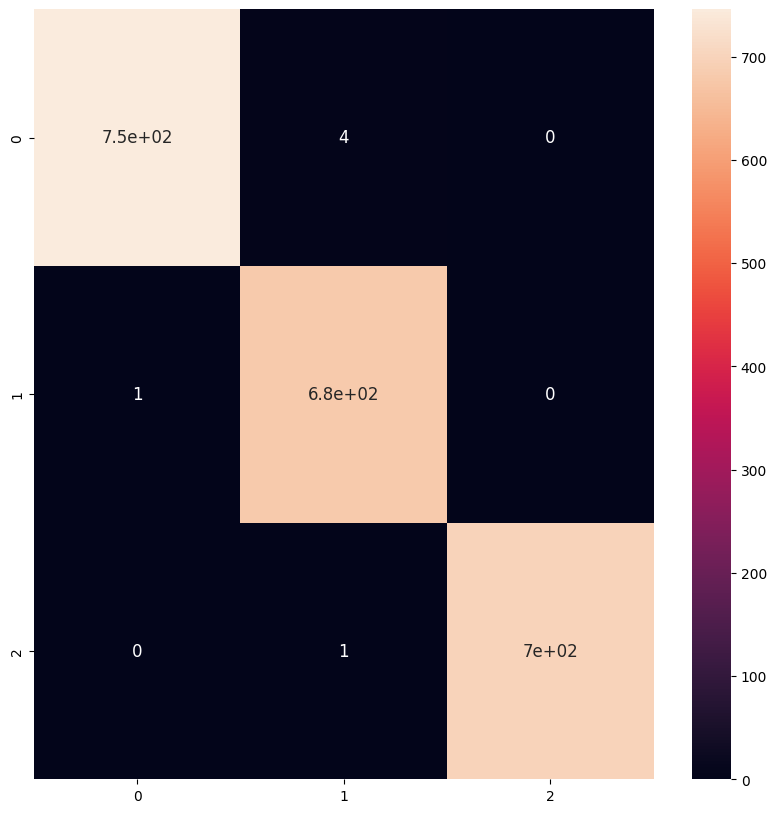

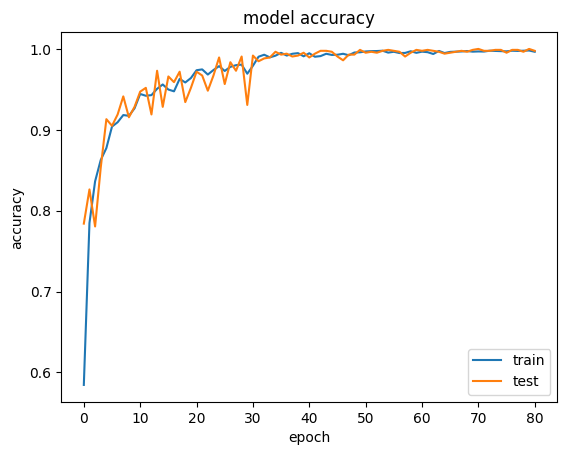

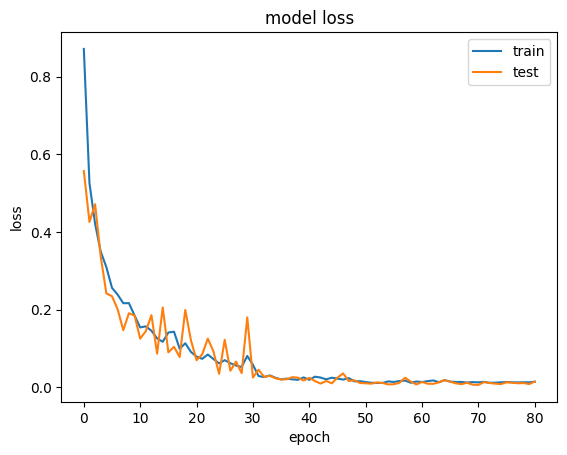

In [ ]:


fnet_blocks = keras.Sequential(
    [FNetLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
learning_rate = 0.001
fnet_classifier = build_classifier(fnet_blocks, positional_encoding=True)
history = run_experiment(fnet_classifier)











In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' contains training information
train_accuracy = history.history['acc']  # Use 'acc' instead of 'accuracy'
val_accuracy = history.history['val_acc']  # Use 'val_acc' instead of 'val_accuracy'
epochs = range(1, len(train_accuracy) + 1)

# Create a line plot for training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(False)
plt.show()



KeyError: ignored

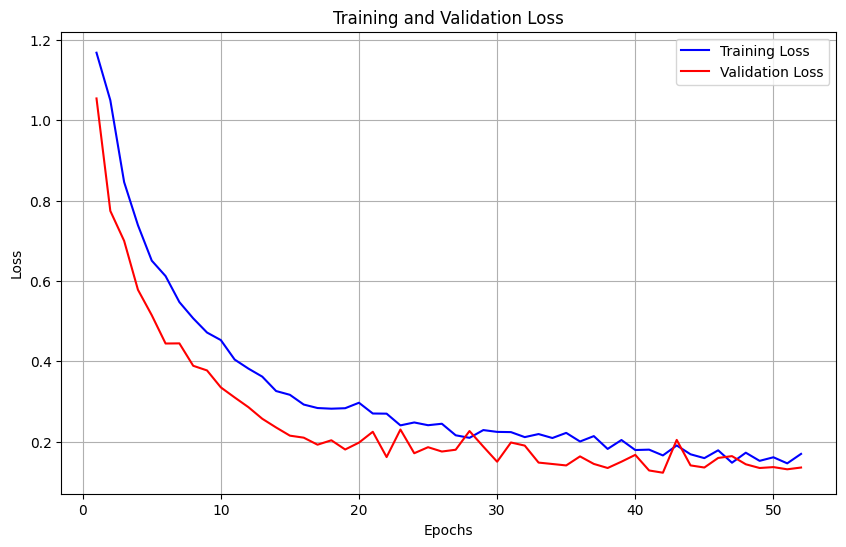

In [ ]:
# Assuming 'history' contains training information
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Create a line plot for training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

gMLP model

In [ ]:
class gMLPLayer(layers.Layer):
    def __init__(self, num_patches, embedding_dim, dropout_rate, *args, **kwargs):
        super(gMLPLayer, self).__init__(*args, **kwargs)

        self.channel_projection1 = keras.Sequential(
            [
                layers.Dense(units=embedding_dim * 2),
                tfa.layers.GELU(),
                layers.Dropout(rate=dropout_rate),
            ]
        )

        self.channel_projection2 = layers.Dense(units=embedding_dim)

        self.spatial_projection = layers.Dense(
            units=num_patches, bias_initializer="Ones"
        )

        self.normalize1 = layers.LayerNormalization(epsilon=1e-6)
        self.normalize2 = layers.LayerNormalization(epsilon=1e-6)

    def spatial_gating_unit(self, x):
        # Split x along the channel dimensions.
        # Tensors u and v will in th shape of [batch_size, num_patchs, embedding_dim].
        u, v = tf.split(x, num_or_size_splits=2, axis=2)
        # Apply layer normalization.
        v = self.normalize2(v)
        # Apply spatial projection.
        v_channels = tf.linalg.matrix_transpose(v)
        v_projected = self.spatial_projection(v_channels)
        v_projected = tf.linalg.matrix_transpose(v_projected)
        # Apply element-wise multiplication.
        return u * v_projected

    def call(self, inputs):
        # Apply layer normalization.
        x = self.normalize1(inputs)
        # Apply the first channel projection. x_projected shape: [batch_size, num_patches, embedding_dim * 2].
        x_projected = self.channel_projection1(x)
        # Apply the spatial gating unit. x_spatial shape: [batch_size, num_patches, embedding_dim].
        x_spatial = self.spatial_gating_unit(x_projected)
        # Apply the second channel projection. x_projected shape: [batch_size, num_patches, embedding_dim].
        x_projected = self.channel_projection2(x_spatial)
        # Add skip connection.
        return x + x_projected

In [ ]:
gmlp_blocks = keras.Sequential(
    [gMLPLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
learning_rate = 0.003
gmlp_classifier = build_classifier(gmlp_blocks)
history = run_experiment(gmlp_classifier)

Epoch 1/100
169/169 [==============================] - 13s 56ms/step - loss: 0.5560 - acc: 0.7298 - top5-acc: 1.0000 - val_loss: 0.3726 - val_acc: 0.8208 - val_top5-acc: 1.0000 - lr: 0.0030
Epoch 2/100
169/169 [==============================] - 9s 51ms/step - loss: 0.3623 - acc: 0.8374 - top5-acc: 1.0000 - val_loss: 0.3402 - val_acc: 0.8417 - val_top5-acc: 1.0000 - lr: 0.0030
Epoch 3/100
169/169 [==============================] - 9s 52ms/step - loss: 0.2911 - acc: 0.8694 - top5-acc: 1.0000 - val_loss: 0.2466 - val_acc: 0.8975 - val_top5-acc: 1.0000 - lr: 0.0030
Epoch 4/100
169/169 [==============================] - 9s 51ms/step - loss: 0.2524 - acc: 0.8904 - top5-acc: 1.0000 - val_loss: 0.2244 - val_acc: 0.9046 - val_top5-acc: 1.0000 - lr: 0.0030
Epoch 5/100
169/169 [==============================] - 9s 50ms/step - loss: 0.2227 - acc: 0.9052 - top5-acc: 1.0000 - val_loss: 0.1764 - val_acc: 0.9250 - val_top5-acc: 1.0000 - lr: 0.0030
Epoch 6/100
169/169 [==============================] -

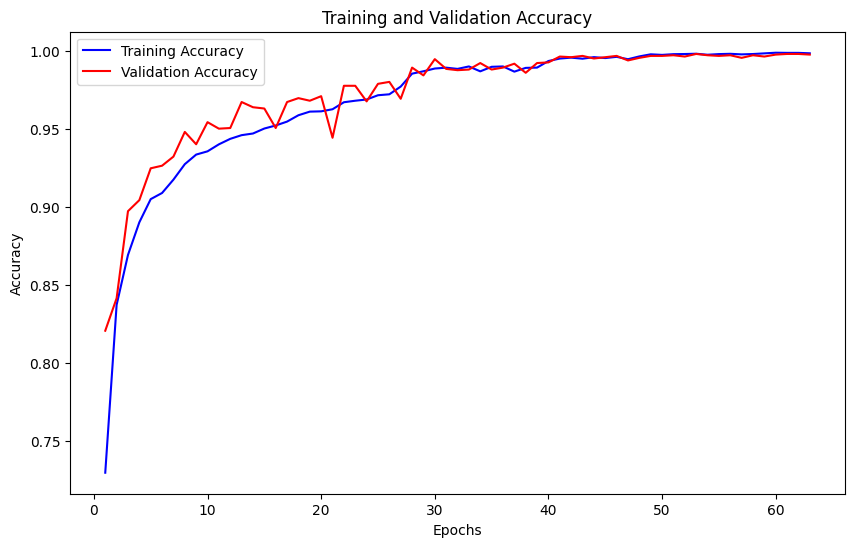

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' contains training information
train_accuracy = history.history['acc']  # Use 'acc' instead of 'accuracy'
val_accuracy = history.history['val_acc']  # Use 'val_acc' instead of 'val_accuracy'
epochs = range(1, len(train_accuracy) + 1)

# Create a line plot for training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(False)
plt.show()



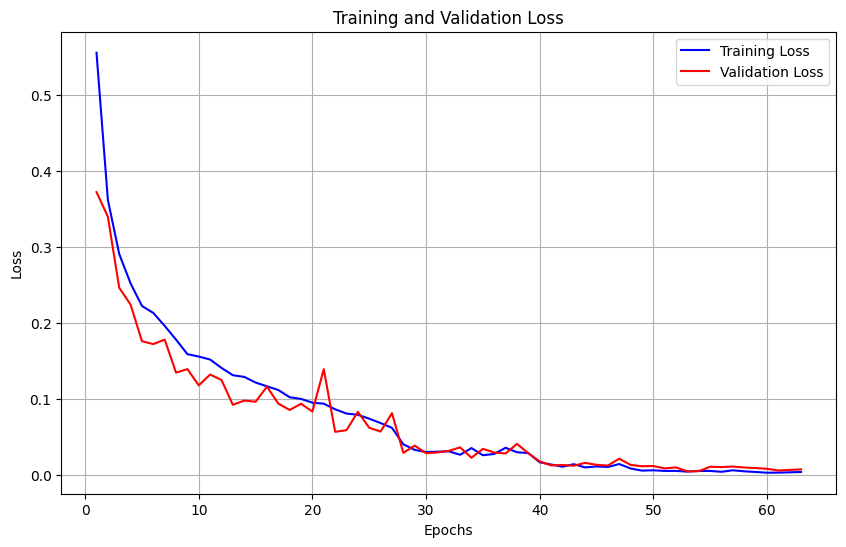

In [ ]:
# Assuming 'history' contains training information
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Create a line plot for training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()